# AddressBasePlus

Processing of AddressBase Plus gpkg to give list of UPRNs and corresponding TOIDs for residential properties. Got ABP gpkg for the whole of GB, 16GB, from OS Ian Bennet.

Used QGIS to select only ADP points within the 1980 AP area. Think this will only contain the Point geometries and no other layer though.


## Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import mplleaflet
import folium
import fiona
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_column', 100) #set max number of cols to display before ...

from rasterio._base import gdal_version
import rasterio
import contextily
import shapely as shp

In [2]:
#check correct environment is being used: parkprov
print(sys.executable)

/Users/tamsinforbes/anaconda3/envs/parkprov/bin/python


## Load 1980 points file

In [3]:
abp1980_path = "../data/addressBasePlus1980/addressBasePlus1980.gpkg"

In [4]:
for layername in fiona.listlayers(abp1980_path):
    with fiona.open(abp1980_path, layer=layername) as src:
        print(layername, len(src))

addressBasePlus1980 4418


In [5]:
abp1980 = gpd.read_file(abp1980_path)

In [6]:
abp1980

,ogc_fid,uprn,udprn,change_type,state,state_date,class,parent_uprn,x_coordinate,y_coordinate,latitude,longitude,rpc,local_custodian_code,country,la_start_date,last_update_date,entry_date,rm_organisation_name,la_organisation,department_name,legal_name,sub_building_name,building_name,building_number,sao_start_number,sao_start_suffix,sao_end_number,sao_end_suffix,sao_text,alt_language_sao_text,pao_start_number,pao_start_suffix,pao_end_number,pao_end_suffix,pao_text,alt_language_pao_text,usrn,usrn_match_indicator,area_name,level,official_flag,os_address_toid,os_address_toid_version,os_roadlink_toid,os_roadlink_toid_version,os_topo_toid,os_topo_toid_version,voa_ct_record,voa_ndr_record,street_description,alt_language_street_description,dependent_thoroughfare,thoroughfare,welsh_dependent_thoroughfare,welsh_thoroughfare,double_dependent_locality,dependent_locality,locality,welsh_dependent_locality,welsh_double_dependent_locality,town_name,administrative_area,post_town,welsh_post_town,postcode,postcode_locator,postcode_type,delivery_point_suffix,addressbase_postal,po_box_number,ward_code,parish_code,rm_start_date,multi_occ_count,voa_ndr_p_desc_code,voa_ndr_scat_code,alt_language,geometry
0,296806,10025192401,NaN,I,NaN,None,CU01,NaN,519956.15,180778.50,51.513208,-0.272704,1,7655,E,2011-09-16,2019-06-02,2018-11-27,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,ELECTRICITY SUB STATION AT 42 JULIAN AVENUE 18...,,20600958,2,,,N,osgb5000000001197892,7.0,osgb4000000030134752,4,osgb1000003511413,2,NaN,NaN,JULIAN AVENUE,,,,,,,,,,,ACTON,EALING,,,,W3 9JF,,,N,,E05000170,,None,0,,,,POINT (519956.150 180778.500)
1,305783,10025172223,NaN,I,NaN,None,CU11,NaN,519834.90,180341.70,51.509308,-0.274599,1,7655,E,2011-09-16,2019-06-02,2018-11-27,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,PUBLIC TELEPHONE 28M FROM 14 BARLOW ROAD 7M FR...,,20601052,2,,,N,osgb5000000001202676,9.0,osgb4000000030406668,3,osgb1000001778708757,7,NaN,NaN,LEXDEN ROAD,,,,,,,,,,,ACTON,EALING,,,,W3 9LJ,,,N,,E05000188,,None,0,,,,POINT (519834.900 180341.700)
2,318096,10025172224,NaN,I,NaN,None,CT02,NaN,519633.71,180227.30,51.508322,-0.277536,1,7655,E,2011-09-16,2019-01-27,2016-01-15,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,"SHELTER 14M FROM NORTH CHINA RESTAURANT, 305 U...",,20602318,2,,,N,osgb5000000001202678,21.0,osgb4000000030700979,4,osgb1000003512425,4,NaN,NaN,UXBRIDGE ROAD,,,,,,,,,,,ACTON,EALING,,,,W3 9QU,,,N,,E05000188,,None,0,,,,POINT (519633.710 180227.300)
3,327086,10025191384,NaN,I,NaN,None,CU01,NaN,519304.50,180218.50,51.508312,-0.282280,1,7655,E,2011-09-16,2020-01-04,2018-11-27,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,ELECTRICITY SUB STATION 9M FROM 377 UXBRIDGE R...,,20600982,2,,,N,osgb5000000001199570,11.0,osgb4000000030214874,7,osgb1000001778713708,4,NaN,NaN,KING EDWARDS GARDENS,,,,,,,,,,,ACTON,EALING,,,,W3 9RH,,,N,,E05000188,,None,0,,,,POINT (519304.500 180218.500)
4,327308,10025192403,NaN,I,NaN,None,CU01,NaN,519009.85,180705.63,51.512753,-0.286360,1,7655,E,2011-09-16,2020-01-04,2018-11-27,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,ELECTRICITY SUB STATION 22M FROM 2 DANIEL ROAD...,,20600509,2,,,N,osgb5000000001197896,11.0,osgb4000000030215303,6,osgb1000001778685560,6,NaN,NaN,DANIEL ROAD,,,,,,,,,,,EALING,EALING,,,,W5 3RY,,,N,,E05000188,,None,0,,,,POINT (519009.850 180705.630)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4413,36622854,12094157,25797795.0,I,NaN,None,RD02,NaN,519692.00,180122.00,51.507363,-0.276732,1,5270,E,2007-12-27,2018-01-13,2001-08-10,,,,,,,23.0,NaN,,NaN,,,,23.0,,NaN,,,,20600795,1,,,Y,osgb1000002298384380,13.0,osgb4000000030134457,5,osgb1000003512224,5,5.098808e+07,NaN,GUNNERSBURY LANE,,,GUNNERSBURY LANE,,,,,,,,ACTON,EALING,LONDON,,W3 8EA,W3 8EA,S,1D,D,,E05000188,,2012-03-19,0,,,,POINT (519692.000 180122.000)
4414,36623187,12116110,2580

In [12]:
#count values of uprn
abp1980.uprn.value_counts()

12148848    1
12008130    1
12126904    1
12008122    1
12149437    1
           ..
12135711    1
12147997    1
12094747    1
12170520    1
12175361    1
Name: uprn, Length: 4418, dtype: int64

In [13]:
abp1980.os_topo_toid.value_counts()

osgb1000003512688       102
osgb5000005103566383     89
osgb1000003512748        68
osgb1000003509225        64
osgb1000003512681        51
                       ... 
osgb1000003512510         1
osgb1000003511875         1
osgb1000003511871         1
osgb1000003513076         1
osgb1000001778708578      1
Name: os_topo_toid, Length: 1814, dtype: int64

In [9]:
abp1980.dtypes

ogc_fid                   int64
uprn                      int64
udprn                   float64
change_type              object
state                   float64
                         ...   
multi_occ_count           int64
voa_ndr_p_desc_code      object
voa_ndr_scat_code        object
alt_language             object
geometry               geometry
Length: 79, dtype: object

In [10]:
abp1980.shape

(4418, 79)

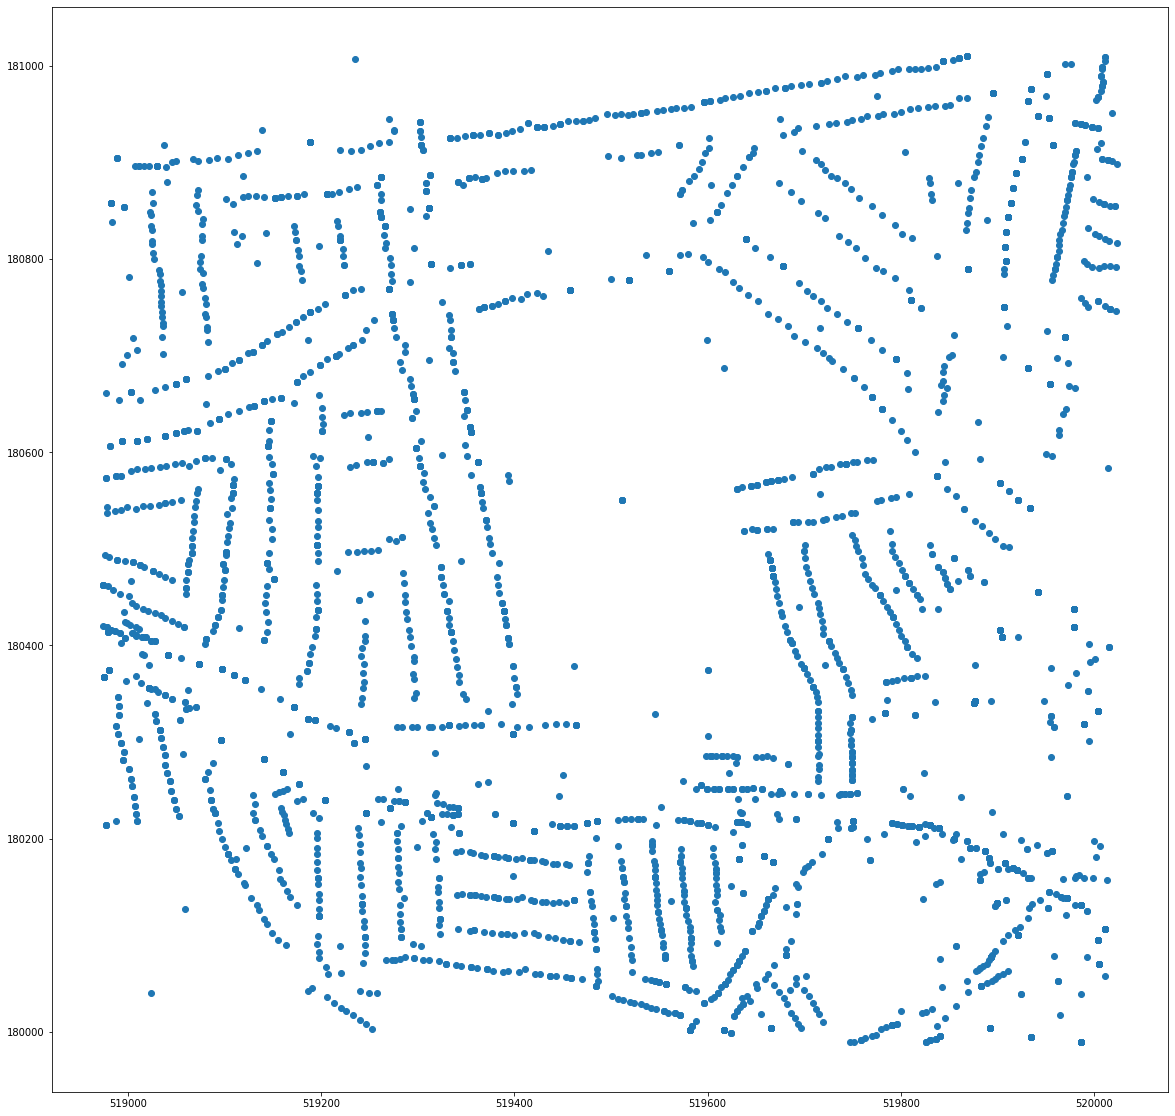

In [8]:
abp1980.plot(figsize=(20,20))

## Apply filters

- RD      Dwelling
- RD01	Caravan
- RD02	Detached
- RD03	Semi-Detached
- RD04	Terraced
- RD06	Self Contained Flat (Includes Maisonette / Apartment)
- RD07	House Boat
- RD08	Sheltered Accommodation
- RD10	Privately Owned Holiday Caravan / Chalet
- RG	Garage
- RG02	Lock-Up Garage / Garage Court

In [18]:
abp1980.head()

,ogc_fid,uprn,udprn,change_type,state,state_date,class,parent_uprn,x_coordinate,y_coordinate,latitude,longitude,rpc,local_custodian_code,country,la_start_date,last_update_date,entry_date,rm_organisation_name,la_organisation,department_name,legal_name,sub_building_name,building_name,building_number,sao_start_number,sao_start_suffix,sao_end_number,sao_end_suffix,sao_text,alt_language_sao_text,pao_start_number,pao_start_suffix,pao_end_number,pao_end_suffix,pao_text,alt_language_pao_text,usrn,usrn_match_indicator,area_name,level,official_flag,os_address_toid,os_address_toid_version,os_roadlink_toid,os_roadlink_toid_version,os_topo_toid,os_topo_toid_version,voa_ct_record,voa_ndr_record,street_description,alt_language_street_description,dependent_thoroughfare,thoroughfare,welsh_dependent_thoroughfare,welsh_thoroughfare,double_dependent_locality,dependent_locality,locality,welsh_dependent_locality,welsh_double_dependent_locality,town_name,administrative_area,post_town,welsh_post_town,postcode,postcode_locator,postcode_type,delivery_point_suffix,addressbase_postal,po_box_number,ward_code,parish_code,rm_start_date,multi_occ_count,voa_ndr_p_desc_code,voa_ndr_scat_code,alt_language,geometry
0,296806,10025192401,NaN,I,NaN,None,CU01,NaN,519956.15,180778.50,51.513208,-0.272704,1,7655,E,2011-09-16,2019-06-02,2018-11-27,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,ELECTRICITY SUB STATION AT 42 JULIAN AVENUE 18...,,20600958,2,,,N,osgb5000000001197892,7.0,osgb4000000030134752,4,osgb1000003511413,2,NaN,NaN,JULIAN AVENUE,,,,,,,,,,,ACTON,EALING,,,,W3 9JF,,,N,,E05000170,,None,0,,,,POINT (519956.150 180778.500)
1,305783,10025172223,NaN,I,NaN,None,CU11,NaN,519834.90,180341.70,51.509308,-0.274599,1,7655,E,2011-09-16,2019-06-02,2018-11-27,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,PUBLIC TELEPHONE 28M FROM 14 BARLOW ROAD 7M FR...,,20601052,2,,,N,osgb5000000001202676,9.0,osgb4000000030406668,3,osgb1000001778708757,7,NaN,NaN,LEXDEN ROAD,,,,,,,,,,,ACTON,EALING,,,,W3 9LJ,,,N,,E05000188,,None,0,,,,POINT (519834.900 180341.700)
2,318096,10025172224,NaN,I,NaN,None,CT02,NaN,519633.71,180227.30,51.508322,-0.277536,1,7655,E,2011-09-16,2019-01-27,2016-01-15,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,"SHELTER 14M FROM NORTH CHINA RESTAURANT, 305 U...",,20602318,2,,,N,osgb5000000001202678,21.0,osgb4000000030700979,4,osgb1000003512425,4,NaN,NaN,UXBRIDGE ROAD,,,,,,,,,,,ACTON,EALING,,,,W3 9QU,,,N,,E05000188,,None,0,,,,POINT (519633.710 180227.300)
3,327086,10025191384,NaN,I,NaN,None,CU01,NaN,519304.50,180218.50,51.508312,-0.282280,1,7655,E,2011-09-16,2020-01-04,2018-11-27,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,ELECTRICITY SUB STATION 9M FROM 377 UXBRIDGE R...,,20600982,2,,,N,osgb5000000001199570,11.0,osgb4000000030214874,7,osgb1000001778713708,4,NaN,NaN,KING EDWARDS GARDENS,,,,,,,,,,,ACTON,EALING,,,,W3 9RH,,,N,,E05000188,,None,0,,,,POINT (519304.500 180218.500)
4,327308,10025192403,NaN,I,NaN,None,CU01,NaN,519009.85,180705.63,51.512753,-0.286360,1,7655,E,2011-09-16,2020-01-04,2018-11-27,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,ELECTRICITY SUB STATION 22M FROM 2 DANIEL ROAD...,,20600509,2,,,N,osgb5000000001197896,11.0,osgb4000000030215303,6,osgb1000001778685560,6,NaN,NaN,DANIEL ROAD,,,,,,,,,,,EALING,EALING,,,,W5 3RY,,,N,,E05000188,,None,0,,,,POINT (519009.850 180705.630)


In [20]:
#create RD filter mask
rdmask = abp1980['class'].str.startswith("RD")

In [22]:
rdabp1980 = abp1980[rdmask]

In [27]:
rdabp1980['class'].value_counts()

RD06    2465
RD03     741
RD04     196
RD02      87
RD08      84
RD         5
Name: class, dtype: int64

In [28]:
#create RG filter mask
rgmask = abp1980['class'].str.startswith("RG")

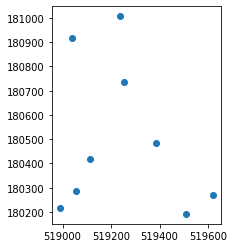

In [30]:
abp1980[rgmask].plot()

# Archive

## Look at ABPlus GB file

In [14]:
abpgb_path = "../data/ABPLUS_EPOCH76_GPKG_GB/ABPLUS_EPOCH76_GPKG_GB.gpkg"

In [15]:
for layername in fiona.listlayers(abpgb_path):
    with fiona.open(abpgb_path, layer=layername) as src:
        print(layername, len(src))

AddressBase_Plus 36815943


In [ ]:
#too big to read - tried and died